In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
from pathlib import Path

WEATHER_PATH = "../data/processed/weather_hourly.parquet"
ZONES_GEOJSON = "../data/processed/zones.geojson"

w = pd.read_parquet(WEATHER_PATH)
z = gpd.read_file(ZONES_GEOJSON)

w["ts"] = pd.to_datetime(w["ts"])
print("Zones:", w.ZoneID.nunique(), "| Rows:", len(w), "| Range:", w["ts"].min(), "→", w["ts"].max())
z.head()

Zones: 223 | Rows: 5095104 | Range: 2023-01-01 05:30:00 → 2025-08-10 04:30:00


,ZoneID,centroid_lat,centroid_lon,Region8,geometry
0,BLR-0001,12.880317,77.476772,SW,"POLYGON ((77.47802 12.87801, 77.47775 12.87814..."
1,BLR-0002,12.898733,77.469049,SW,"POLYGON ((77.47802 12.90369, 77.47802 12.89288..."
2,BLR-0003,12.910828,77.472120,SW,"POLYGON ((77.47802 12.9212, 77.47802 12.90369,..."
3,BLR-0004,12.923789,77.475233,SW,"POLYGON ((77.47802 12.9212, 77.47176 12.9212, ..."
4,BLR-0005,12.948733,77.475552,W,"POLYGON ((77.47802 12.95622, 77.47802 12.93871..."


In [25]:
w.head()

,ZoneID,ts,ghi_whm2,t2m_c,ws10_ms
0,BLR-0001,2023-01-01 05:30:00,0.0,13.8700,2.83
1,BLR-0001,2023-01-01 06:30:00,0.0,13.4647,2.77
2,BLR-0001,2023-01-01 07:30:00,0.0,13.4647,2.68
3,BLR-0001,2023-01-01 08:30:00,0.0,13.4647,2.57
4,BLR-0001,2023-01-01 09:30:00,0.0,13.4647,2.46


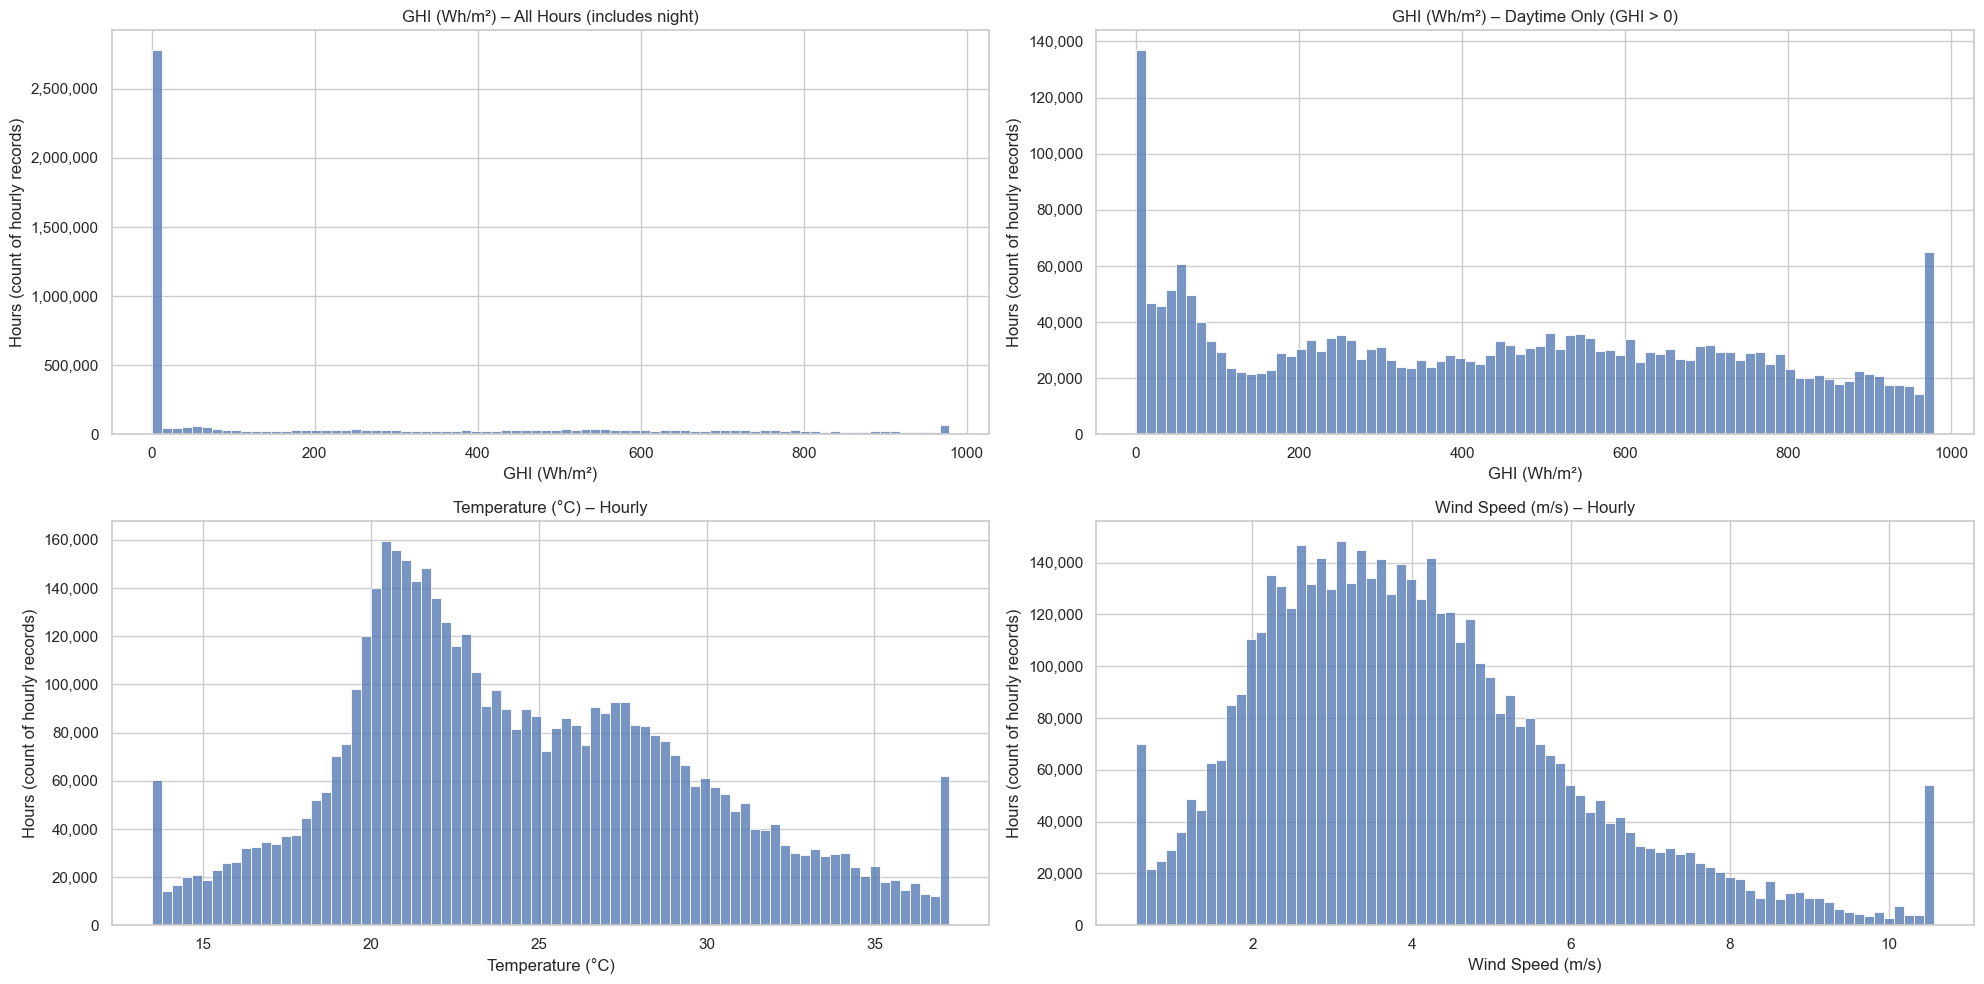

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

def thousands(x, pos):
    # format 12000 -> '12,000'
    return f"{int(x):,}"

# --- Data splits ---
ghi_all = w["ghi_whm2"]
ghi_day = w.loc[w["ghi_whm2"] > 0, "ghi_whm2"]  # daytime only

fig = plt.figure(figsize=(20, 10))

# 1) GHI – ALL HOURS (shows the big night-time spike at 0)
ax1 = plt.subplot(2, 2, 1)
sns.histplot(ghi_all, bins=80, ax=ax1)
ax1.set_title("GHI (Wh/m²) – All Hours (includes night)")
ax1.set_xlabel("GHI (Wh/m²)")
ax1.set_ylabel("Hours (count of hourly records)")
ax1.yaxis.set_major_formatter(FuncFormatter(thousands))

# 2) GHI – DAYTIME ONLY (easier to read distribution)
ax2 = plt.subplot(2, 2, 2)
sns.histplot(ghi_day, bins=80, ax=ax2)
ax2.set_title("GHI (Wh/m²) – Daytime Only (GHI > 0)")
ax2.set_xlabel("GHI (Wh/m²)")
ax2.set_ylabel("Hours (count of hourly records)")
ax2.yaxis.set_major_formatter(FuncFormatter(thousands))

# 3) Temperature
ax3 = plt.subplot(2, 2, 3)
sns.histplot(w["t2m_c"], bins=80, ax=ax3)
ax3.set_title("Temperature (°C) – Hourly")
ax3.set_xlabel("Temperature (°C)")
ax3.set_ylabel("Hours (count of hourly records)")
ax3.yaxis.set_major_formatter(FuncFormatter(thousands))

# 4) Wind speed
ax4 = plt.subplot(2, 2, 4)
sns.histplot(w["ws10_ms"], bins=80, ax=ax4)
ax4.set_title("Wind Speed (m/s) – Hourly")
ax4.set_xlabel("Wind Speed (m/s)")
ax4.set_ylabel("Hours (count of hourly records)")
ax4.yaxis.set_major_formatter(FuncFormatter(thousands))

plt.tight_layout()
plt.show()



In [23]:
total_hours = len(w)
print(f"Total hourly records: {total_hours:,}")


Total hourly records: 5,095,104


In [24]:
rows, cols = w.shape
print(f"Rows: {rows:,}")
print(f"Columns: {cols}")

Rows: 5,095,104
Columns: 5


In [27]:
# expected hours per zone
date_min = w["ts"].min().floor("D")
date_max = w["ts"].max().ceil("D")
expected_hours = int((date_max - date_min) / pd.Timedelta(hours=1))

cov = (w.groupby("ZoneID")["ts"]
         .count()
         .rename("hours_present")
         .reset_index())
cov["hours_expected"] = expected_hours
cov["pct_present"] = cov["hours_present"] / cov["hours_expected"] * 100
cov = cov.sort_values("pct_present")

print("Expected hours per zone:", expected_hours)
cov.head(10), cov["pct_present"].describe()


Expected hours per zone: 22872


(       ZoneID  hours_present  hours_expected  pct_present
 0    BLR-0001          22848           22872    99.895068
 141  BLR-0142          22848           22872    99.895068
 142  BLR-0143          22848           22872    99.895068
 143  BLR-0144          22848           22872    99.895068
 144  BLR-0145          22848           22872    99.895068
 145  BLR-0146          22848           22872    99.895068
 146  BLR-0147          22848           22872    99.895068
 147  BLR-0148          22848           22872    99.895068
 148  BLR-0149          22848           22872    99.895068
 149  BLR-0150          22848           22872    99.895068,
 count    2.230000e+02
 mean     9.989507e+01
 std      1.424283e-14
 min      9.989507e+01
 25%      9.989507e+01
 50%      9.989507e+01
 75%      9.989507e+01
 max      9.989507e+01
 Name: pct_present, dtype: float64)

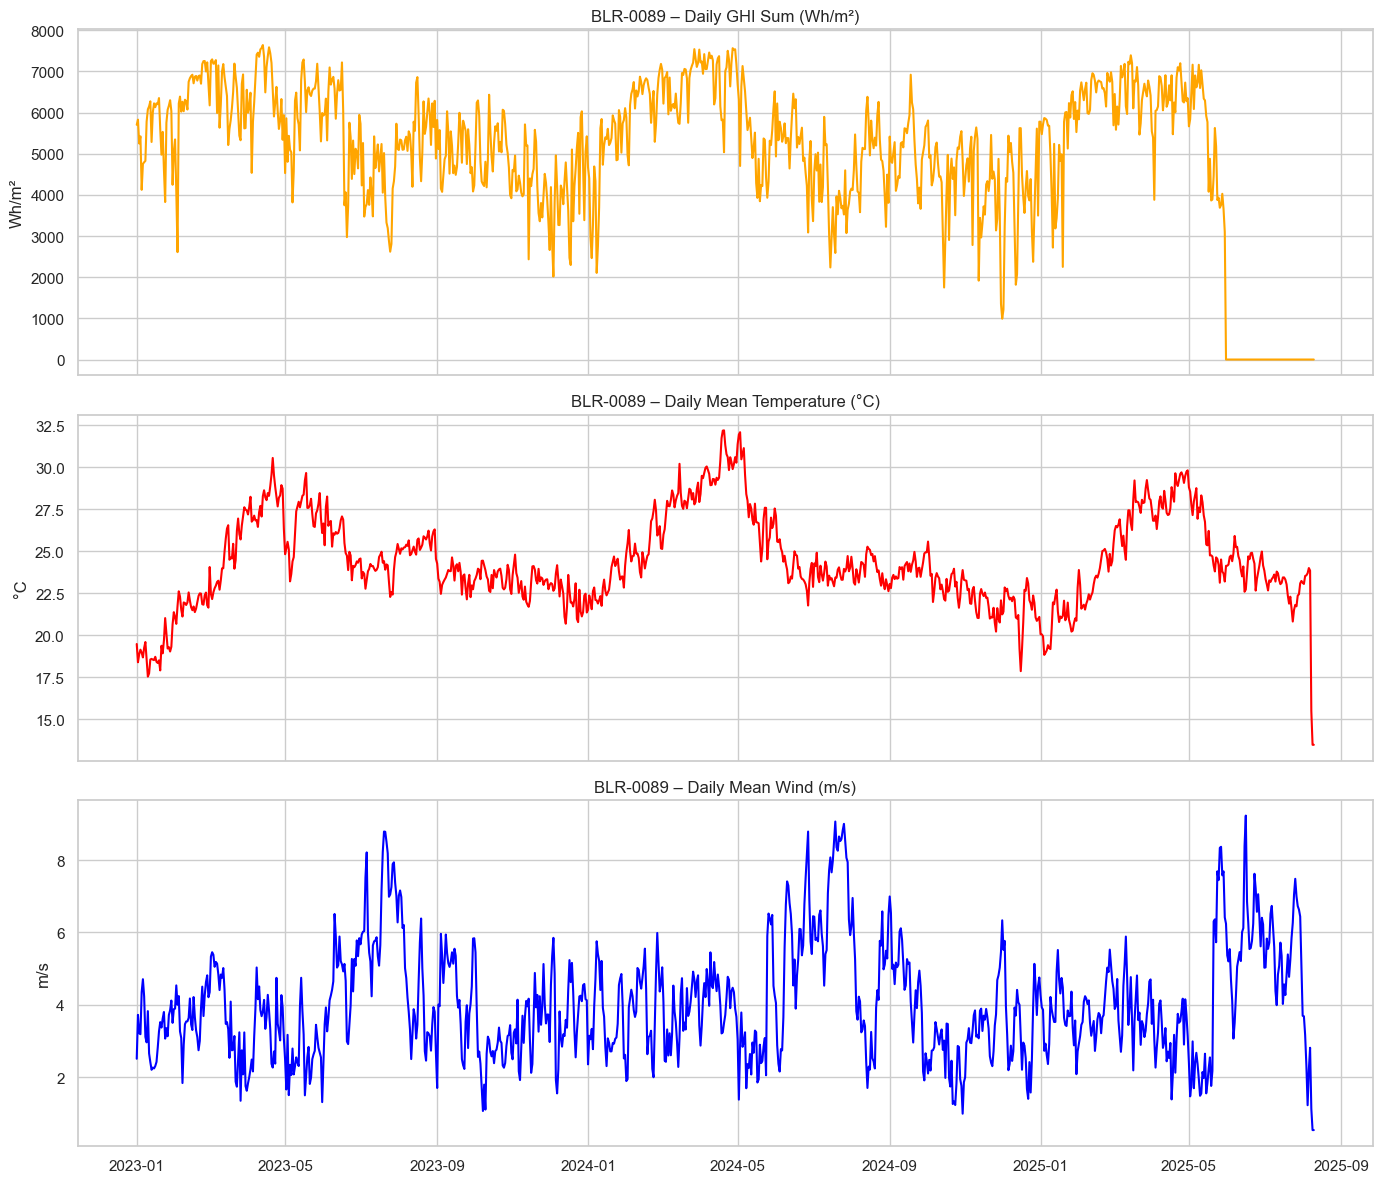

In [32]:
import matplotlib.pyplot as plt

# Pick a ZoneID to visualize
zid = w.ZoneID.unique()[88]

# Resample to daily
d = (
    w[w.ZoneID == zid]
    .set_index("ts")
    .resample("D")
    .agg(
        ghi_sum=("ghi_whm2", "sum"),
        t2m_mean=("t2m_c", "mean"),
        ws10_mean=("ws10_ms", "mean")
    )
    .reset_index()
)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Daily GHI
axes[0].plot(d["ts"], d["ghi_sum"], color="orange")
axes[0].set_title(f"{zid} – Daily GHI Sum (Wh/m²)")
axes[0].set_ylabel("Wh/m²")

# Daily Temperature
axes[1].plot(d["ts"], d["t2m_mean"], color="red")
axes[1].set_title(f"{zid} – Daily Mean Temperature (°C)")
axes[1].set_ylabel("°C")

# Daily Wind Speed
axes[2].plot(d["ts"], d["ws10_mean"], color="blue")
axes[2].set_title(f"{zid} – Daily Mean Wind (m/s)")
axes[2].set_ylabel("m/s")

plt.tight_layout()
plt.show()


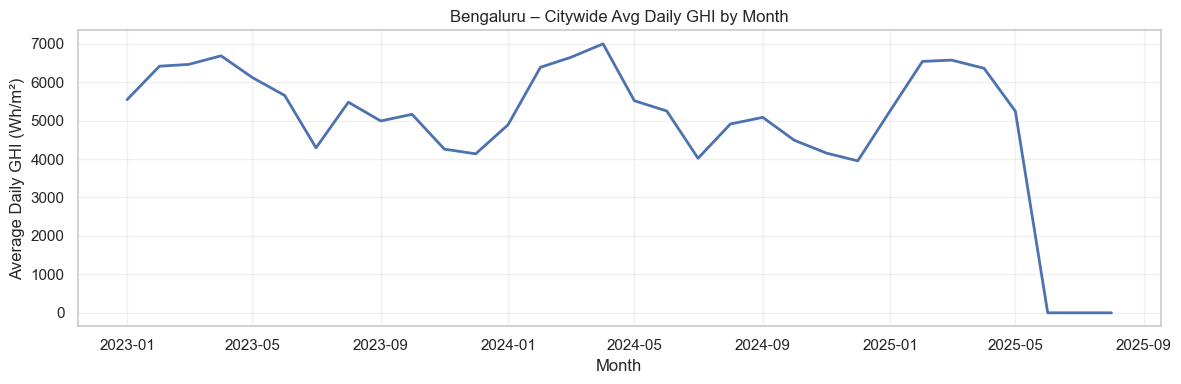

In [ ]:
# 1) Daily GHI per zone
wd = (
    w.assign(date=w["ts"].dt.floor("D"))               # make a proper date column
     .groupby(["ZoneID", "date"], as_index=False)
     .agg(ghi_sum=("ghi_whm2", "sum"))
)

# 2) Monthly average across the city (mean of daily-averaged zones)
m = (
    wd.assign(month=wd["date"].dt.to_period("M").dt.to_timestamp())
      .groupby("month", as_index=False)
      .agg(ghi_sum=("ghi_sum", "mean"))
      .sort_values("month")
)

# 3) Plot (Matplotlib)
plt.figure(figsize=(12,4))
plt.plot(m["month"], m["ghi_sum"], linewidth=2)
plt.title("Bengaluru – Citywide Avg Daily GHI by Month")
plt.xlabel("Month")
plt.ylabel("Average Daily GHI (Wh/m²)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


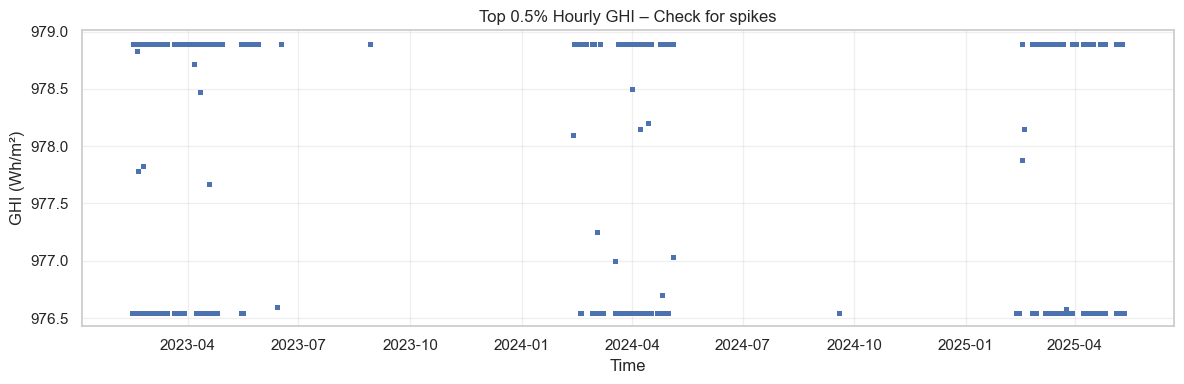

In [38]:
thr = w["ghi_whm2"].quantile(0.995)
hi = w[w["ghi_whm2"] >= thr].copy()

plt.figure(figsize=(12,4))
plt.scatter(hi["ts"], hi["ghi_whm2"], s=6, alpha=0.6)
plt.title("Top 0.5% Hourly GHI – Check for spikes")
plt.xlabel("Time")
plt.ylabel("GHI (Wh/m²)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


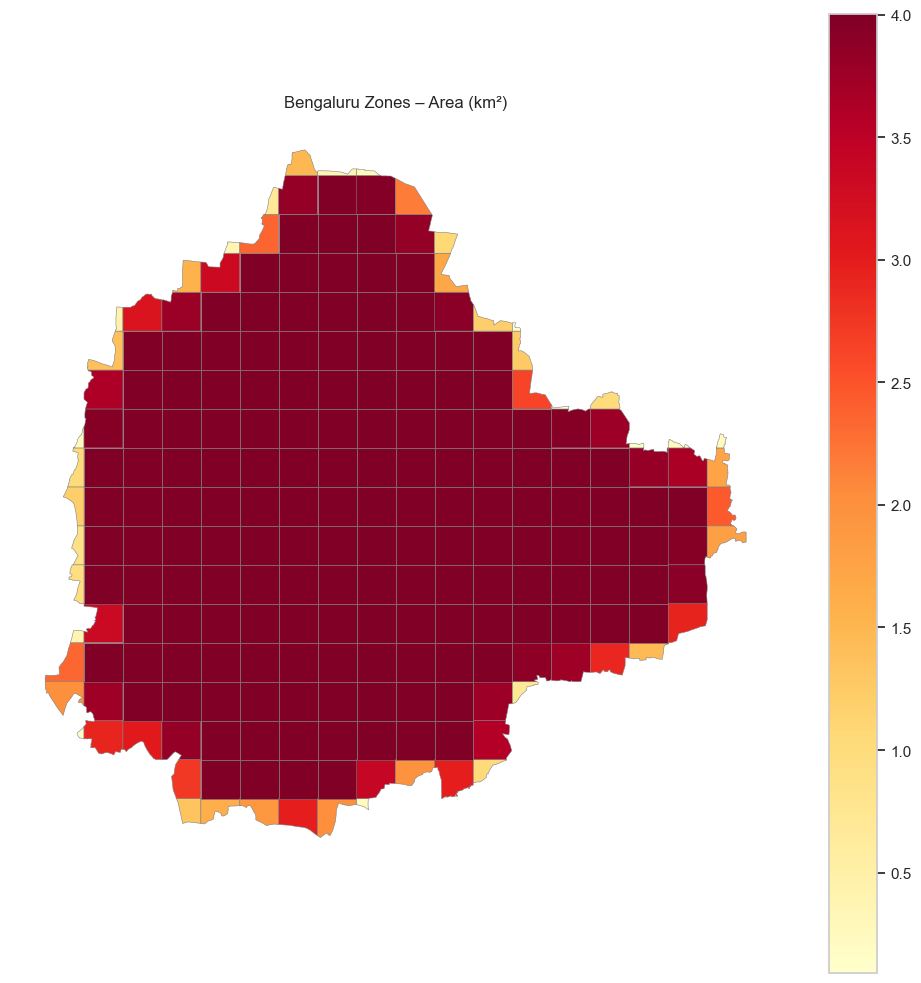

In [ ]:
# z is your zones GeoDataFrame in EPSG:4326
z_m = z.to_crs(3857)
z["area_km2"] = z_m.area / 1e6

fig, ax = plt.subplots(figsize=(10,10))
z.plot(column="area_km2", ax=ax, cmap="YlOrRd", edgecolor="gray", linewidth=0.4, legend=True)
ax.set_title("Bengaluru Zones – Area (km²)")
ax.axis("off")
plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

area_km2 = (z.to_crs(3857).area / 1e6).rename("area_km2")
zone_area = pd.DataFrame({"ZoneID": z["ZoneID"], "area_km2": area_km2})
summary = zone_area.merge(cov, on="ZoneID", how="left").sort_values("ZoneID")
summary["hours_missing"] = summary["hours_expected"] - summary["hours_present"]

print(summary.head(10).to_string(index=False))
summary.to_csv("../data/processed/phase2_zone_coverage.csv", index=False)


  ZoneID  area_km2  hours_present  hours_expected  pct_present  hours_missing
BLR-0001  0.137871          22848           22872    99.895068             24
BLR-0002  2.005565          22848           22872    99.895068             24
BLR-0003  2.342631          22848           22872    99.895068             24
BLR-0004  0.378725          22848           22872    99.895068             24
BLR-0005  0.956173          22848           22872    99.895068             24
BLR-0006  0.879514          22848           22872    99.895068             24
BLR-0007  1.205699          22848           22872    99.895068             24
BLR-0008  1.029935          22848           22872    99.895068             24
BLR-0009  0.266934          22848           22872    99.895068             24
BLR-0010  2.922213          22848           22872    99.895068             24


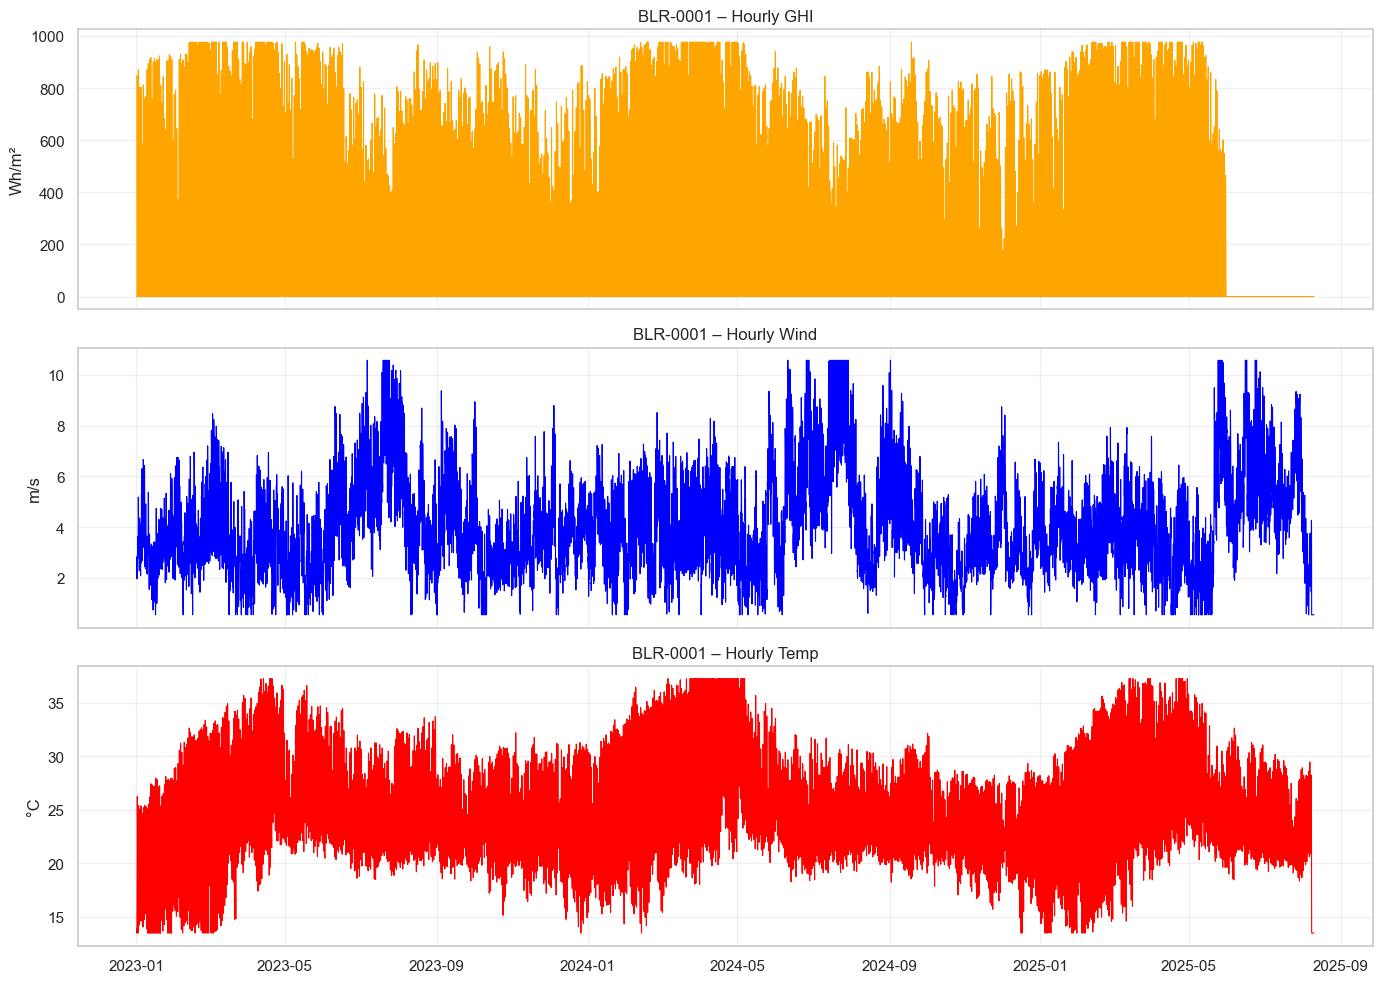

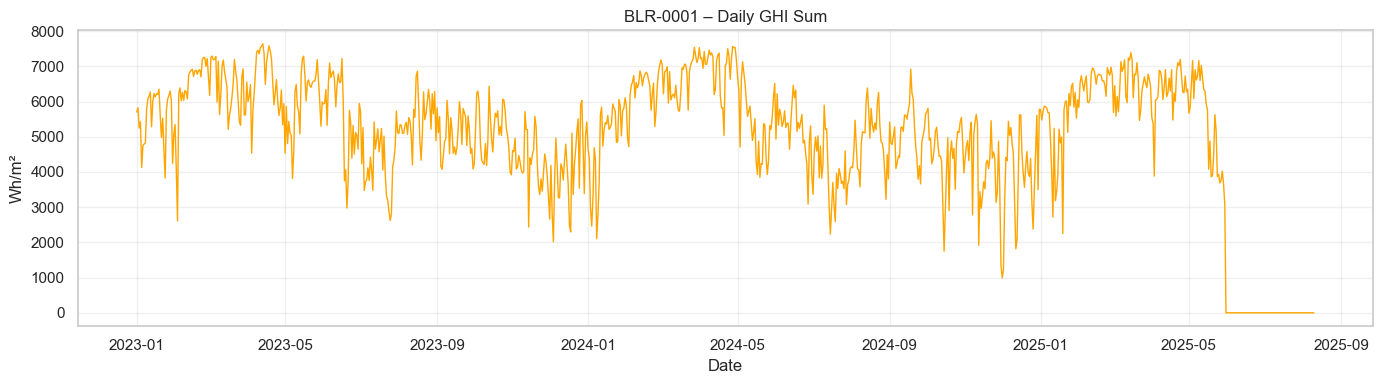

In [ ]:
def inspect_zone(zid: str, hours=True, daily=True):
    df = w[w.ZoneID == zid].copy()
    df = df.sort_values("ts")

    if hours:
        fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
        axes[0].plot(df["ts"], df["ghi_whm2"], color="orange", linewidth=0.8)
        axes[0].set_title(f"{zid} – Hourly GHI")
        axes[0].set_ylabel("Wh/m²"); axes[0].grid(True, alpha=0.3)

        axes[1].plot(df["ts"], df["ws10_ms"], color="blue", linewidth=0.8)
        axes[1].set_title(f"{zid} – Hourly Wind")
        axes[1].set_ylabel("m/s"); axes[1].grid(True, alpha=0.3)

        axes[2].plot(df["ts"], df["t2m_c"], color="red", linewidth=0.8)
        axes[2].set_title(f"{zid} – Hourly Temp")
        axes[2].set_ylabel("°C"); axes[2].grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()

    if daily:
        d = (df.set_index("ts").resample("D")
               .agg(ghi_sum=("ghi_whm2","sum"),
                    ws10_mean=("ws10_ms","mean"),
                    t2m_mean=("t2m_c","mean"))
               .reset_index())

        fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        ax.plot(d["ts"], d["ghi_sum"], color="orange", linewidth=1.0)
        ax.set_title(f"{zid} – Daily GHI Sum")
        ax.set_xlabel("Date"); ax.set_ylabel("Wh/m²")
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

# example:
inspect_zone(w.ZoneID.unique()[0], hours=True, daily=True)
